In [1]:
import pandas as pd
import numpy as np 
import zipfile
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average, Reshape
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

In [3]:
from keras.callbacks import EarlyStopping

In [4]:
zf = zipfile.ZipFile('/home/elena/Downloads/ml-100k.zip')
# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(zf.open('ml-100k/u.data'), sep='\t', names=r_cols,encoding='latin-1')
print("\nRatings Data :")
print("shape : ", ratings.shape)
print(ratings.head())


Ratings Data :
shape :  (100000, 4)
   user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596


In [5]:
n_movies = len(ratings.movie_id.unique())
n_users = len(ratings.user_id.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(ratings),
    )
)

943 distinct users rated 1,682 different movies (total ratings = 100,000)


In [6]:
ratings.rating.min(), ratings.rating.max(), ratings.rating.unique()

(1, 5, array([3, 1, 2, 4, 5]))

In [7]:
# The dataset has already been divided into train and test by GroupLens where the test data has 10 ratings for # each user, i.e. 9,430 rows in total!  Reading both these files into our Python environment
train = pd.read_csv(zf.open('ml-100k/ua.base'), sep='\t', names=r_cols, encoding='latin-1')
test = pd.read_csv(zf.open('ml-100k/ua.test'), sep='\t', names=r_cols, encoding='latin-1')
train.shape, test.shape

((90570, 4), (9430, 4))

In [8]:
n_movies = len(train.movie_id.unique())
n_users = len(train.user_id.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(train),
    )
)

943 distinct users rated 1,680 different movies (total ratings = 90,570)


In [9]:
n_movies = len(test.movie_id.unique())
n_users = len(test.user_id.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(test),
    )
)

943 distinct users rated 1,129 different movies (total ratings = 9,430)


In [9]:
# train test split
# Shuffle (reproducibly)
df = ratings.sample(frac=1, random_state=1).reset_index(drop=True)

# Partitioning train/val according to behaviour of keras.Model.fit() when called with
# validation_split kwarg (which is to take validation data from the end as a contiguous
# chunk)
val_split = .2
n_ratings = len(df)
n_train = math.floor(n_ratings * (1-val_split))
itrain = df.index[:n_train]
ival = df.index[n_train:]
train=df.loc[itrain]
test=df.loc[ival]
# center rating
mean_rating_train =  df.loc[itrain, 'rating'].mean()
df['y'] = df['rating'] -mean_rating_train

In [10]:
# baseline
def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = test['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = ratings.copy().set_index('movie_id')
mean_per_movie = train.groupby('movie_id')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = train.groupby('movie_id').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = test.join(mean_per_movie, on='movie_id', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 3.52 stars
Always predicting global average rating results in Mean Absolute Error=0.94, Mean Squared Error=1.26
Predicting mean per movie results in Mean Absolute Error=0.84, Mean Squared Error=1.09


In [11]:
def embedding_model(movie_embedding_size, user_embedding_size, user_max, movie_max):
    hidden_units = (32,4)

    # Each instance will consist of two inputs: a single user id, and a single movie id
    user_id_input = Input(shape=(1,), name='user_id')
    movie_id_input = Input(shape=(1,), name='movie_id')
    user_embedded = Embedding(user_max+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(movie_max+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
    # Concatenate the embeddings (and remove the useless extra dimension)
    concatenated = Concatenate()([user_embedded, movie_embedded])
    out = Flatten()(concatenated)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)

    model = Model(inputs = [user_id_input, movie_id_input],outputs = out)
    #compile
    model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
    return model

In [14]:
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)

In [12]:
model = embedding_model(8,8,ratings.user_id.max(), ratings.movie_id.max())

In [16]:
history = model.fit(x=[train.user_id.values, train.movie_id.values], y= train.rating.values, batch_size=500, epochs=20, verbose=1 )

Epoch 1/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8717 - MAE: 0.7382
Epoch 2/20
182/182 [==============================] - 0s 3ms/step - loss: 0.8592 - MAE: 0.7320
Epoch 3/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8555 - MAE: 0.7302
Epoch 4/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8534 - MAE: 0.7294
Epoch 5/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8522 - MAE: 0.7289
Epoch 6/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8515 - MAE: 0.7286
Epoch 7/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8507 - MAE: 0.7280
Epoch 8/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8502 - MAE: 0.7279
Epoch 9/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8495 - MAE: 0.7273
Epoch 10/20
182/182 [==============================] - 0s 2ms/step - loss: 0.8495 - MAE: 0.7280
Epoch 11/20
182/182 [============================

In [17]:
validation = model.evaluate(x=[test.user_id.values, test.movie_id.values], y=test.rating.values)

295/295 [==============================] - 1s 2ms/step - loss: 0.9207 - MAE: 0.7589


In [18]:
validation

[0.9207122325897217, 0.7588593363761902]

In [17]:
history = model.fit(x=[df.user_id, df.movie_id], y= df.rating, batch_size=500, epochs=20, verbose=1, validation_split=.1,callbacks=[es] )

Epoch 1/20
180/180 [==============================] - 0s 2ms/step - loss: 1.9169 - MAE: 1.0242 - val_loss: 0.8898 - val_MAE: 0.7450
Epoch 2/20
180/180 [==============================] - 0s 2ms/step - loss: 0.8583 - MAE: 0.7315 - val_loss: 0.8847 - val_MAE: 0.7440
Epoch 3/20
180/180 [==============================] - 0s 2ms/step - loss: 0.8551 - MAE: 0.7302 - val_loss: 0.8829 - val_MAE: 0.7421
Epoch 4/20
180/180 [==============================] - 0s 2ms/step - loss: 0.8542 - MAE: 0.7298 - val_loss: 0.8836 - val_MAE: 0.7422


In [8]:
from sklearn.model_selection import train_test_split
import math

In [16]:
history = model.fit(x=[df.user_id, df.movie_id], y= df.y, batch_size=500, epochs=20, verbose=1, validation_split=.2,callbacks=[es] )

Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 1.8364 - MAE: 1.0416 - val_loss: 0.9296 - val_MAE: 0.7658
Epoch 2/20
160/160 [==============================] - 0s 3ms/step - loss: 0.8642 - MAE: 0.7374 - val_loss: 0.8873 - val_MAE: 0.7430
Epoch 3/20
160/160 [==============================] - 0s 3ms/step - loss: 0.8451 - MAE: 0.7278 - val_loss: 0.8835 - val_MAE: 0.7406
Epoch 4/20
160/160 [==============================] - 1s 3ms/step - loss: 0.8407 - MAE: 0.7254 - val_loss: 0.8819 - val_MAE: 0.7415


In [21]:
def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = test['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = df.copy().set_index('movie_id')
mean_per_movie = train.groupby('movie_id')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = train.groupby('movie_id').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = test.join(mean_per_movie, on='movie_id', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 3.50 stars
Always predicting global average rating results in Mean Absolute Error=0.83, Mean Squared Error=1.10
Predicting mean per movie results in Mean Absolute Error=0.76, Mean Squared Error=0.96


In [54]:
import matplotlib.pyplot as plt

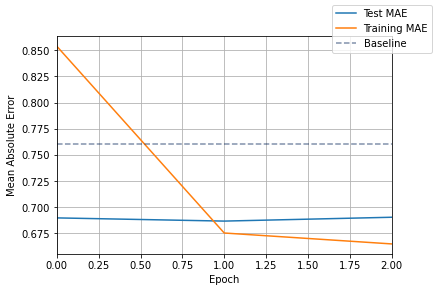

In [55]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['val_MAE'], label='Test MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.76
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend()
plt.savefig('output.png', dpi=400, bbox_inches='tight')
plt.show()

In [64]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler_single = MinMaxScaler(feature_range = (0, 1))

In [65]:
train_scaled = np.concatenate([scaler.fit_transform(train[['user_id', 'movie_id']]), 
                                  scaler_single.fit_transform(train[['rating']])], axis = 1)

In [66]:
test_scaled = np.concatenate([scaler.transform(test[['user_id', 'movie_id']]), 
                                  scaler_single.transform(test[['rating']])], axis = 1)

In [67]:
df_scaled = np.concatenate([scaler.fit_transform(df[['user_id', 'movie_id']]), 
                                  scaler_single.fit_transform(df[['rating']])], axis = 1)

In [69]:
df_s = pd.DataFrame(df_scaled, columns = ['user_id', 'movie_id', 'rating'])

In [70]:
model2 = embedding_model(8,8,1,1)
history = model2.fit(x=[df_s.user_id, df_s.movie_id], y= df_s.rating, batch_size=500, epochs=20, verbose=1, validation_split=.2,callbacks=[es] )

Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 0.1788 - MAE: 0.3460 - val_loss: 0.0797 - val_MAE: 0.2361
Epoch 2/20
160/160 [==============================] - 0s 3ms/step - loss: 0.0791 - MAE: 0.2360 - val_loss: 0.0797 - val_MAE: 0.2365


In [72]:
train_s = pd.DataFrame(train_scaled, columns = ['user_id', 'movie_id', 'rating'])
test_s = pd.DataFrame(test_scaled, columns = ['user_id', 'movie_id', 'rating'])

In [73]:
def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = train_s['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = test_s['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = df_s.copy().set_index('movie_id')
mean_per_movie = train_s.groupby('movie_id')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = train_s.groupby('movie_id').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = test_s.join(mean_per_movie, on='movie_id', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 0.63 stars
Always predicting global average rating results in Mean Absolute Error=0.24, Mean Squared Error=0.08
Predicting mean per movie results in Mean Absolute Error=0.20, Mean Squared Error=0.07


In [57]:
#Example predictions
ratings_per_user = df.groupby('user_id').size()
uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=1).index[0]
user_ratings = df[df.user_id==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
cols = ['user_id', 'movie_id', 'rating']
user_ratings.sort_values(by='rating', ascending=False)[cols]

User #819 has rated 28 movies (avg. rating = 4.1):


,user_id,movie_id,rating
90249,819,248,5
75648,819,286,5
21521,819,346,5
75380,819,315,5
75129,819,302,5
30243,819,744,5
44121,819,147,5
46462,819,1537,5
70443,819,300,5
53149,819,340,5


In [61]:
user_ratings_test = test[test.user_id == uid]
# predicting for user uid movies from test set
y_pred = model.predict([user_ratings_test.user_id, user_ratings_test.movie_id])
y_true = user_ratings_test.rating
result = pd.DataFrame()
result['predicted_rating'] = np.squeeze(y_pred) + mean_rating_train
result['true_rating'] = y_true.values 
result['error'] = abs(np.squeeze(y_pred) + mean_rating_train - np.squeeze(y_true.values))
result.sort_values(by='error', ascending=False)[['true_rating', 'predicted_rating', 'error']]

,true_rating,predicted_rating,error
1,4,4.627240,0.627240
0,5,4.403569,0.596431


In [62]:
uid = 557
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
cols = ['user_id', 'movie_id', 'rating']
user_ratings.sort_values(by='rating', ascending=False)[cols]

User #557 has rated 28 movies (avg. rating = 4.1):


,user_id,movie_id,rating
90249,819,248,5
75648,819,286,5
21521,819,346,5
75380,819,315,5
75129,819,302,5
30243,819,744,5
44121,819,147,5
46462,819,1537,5
70443,819,300,5
53149,819,340,5


In [63]:
user_ratings_test = test[test.user_id == uid]
# predicting for user uid movies from test set
y_pred = model.predict([user_ratings_test.user_id, user_ratings_test.movie_id])
y_true = user_ratings_test.rating
result = pd.DataFrame()
result['predicted_rating'] = np.squeeze(y_pred) + mean_rating_train
result['true_rating'] = y_true.values 
result['error'] = abs(np.squeeze(y_pred) + mean_rating_train - np.squeeze(y_true.values))
result.sort_values(by='error', ascending=False)[['true_rating', 'predicted_rating', 'error']]

,true_rating,predicted_rating,error
6,1,3.552361,2.552361
1,5,4.161126,0.838874
10,5,4.275356,0.724644
3,4,3.425429,0.574571
4,3,3.477437,0.477437
8,3,3.396739,0.396739
0,4,4.382671,0.382671
5,3,3.279621,0.279621
9,4,3.778014,0.221986
7,3,2.854178,0.145822
